# Circle radius test
Learn the function $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ where $f:\bf{x} \mapsto |x|$ with a deep neural network and compute the mutual information changes between the input, the different layer outputs and the output.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.spatial as ss
from scipy.special import digamma
from math import log

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam

/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_learning_curve(fitting_history):
    plt.clf()
    plt.figure(figsize=(10, 10))

    plt.subplot(2,1,1)
    plt.plot(fitting_history['loss'], color='steelblue')
    plt.plot(fitting_history['val_loss'], color='orange')
    plt.legend(['Training loss', 'Testing loss'])

    plt.subplot(2,1,2)
    plt.plot(fitting_history['acc'], color='steelblue')
    plt.plot(fitting_history['val_acc'], color='orange')
    plt.legend(['Training accuracy', 'Testing accuracy'])

    plt.show()

## Define function and generate random samples

In [17]:
def f(x):
    return np.where(np.sqrt(np.sum(x * x)) > 1.15, 1, 0)

In [147]:
dimensions = 4

np.random.seed(42)
X_train = np.random.uniform(-1, 1, size=[20000, dimensions])
Y_train = np.apply_along_axis(f, 1, X_train)

X_test = np.random.uniform(-1, 1, size=[10000, dimensions])
Y_test = np.apply_along_axis(f, 1, X_test)

In [148]:
pd.DataFrame(Y_train).describe()

,0
count,20000.00000
mean,0.47995
std,0.49961
min,0.00000
25%,0.00000
50%,0.00000
75%,1.00000
max,1.00000


## Mutual information and entropy functions

In [149]:
def entropy(x, k=3, base=2, seed=None):
    assert k < len(x)
    d, N = len(x[0]), len(x)
    
    if seed:
        np.random.seed(seed)
    intens = 1e-10
    small_noise_x = x + intens * np.random.rand(d)
    
    tree = ss.cKDTree(small_noise_x)
    nn = tree.query(small_noise_x, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]

    const = digamma(N) - digamma(k) + d * log(2)
    return (const + d * np.mean(np.log(nn))) / log(base)

In [150]:
def avg_digamma(points, dvec):
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    
    for i in range(N):
        dist = dvec[i]
        num_points = len(tree.query_ball_point(points[i], dist - 1e-15, p=float('inf')))
        avg += digamma(num_points) / N
        
    return avg

In [151]:
def mutual_information(x, y, k=3, base=2, seed=None):
    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    
    if seed:
        np.random.seed(seed)
    intens = 1e-6
    x_noise = x + intens * np.random.rand(len(x[0]))
    y_noise = y + intens * np.random.rand(len(y[0]))
    points = np.concatenate([x_noise, y_noise], axis=1)
                   
    tree = ss.cKDTree(points)
    dvec = tree.query(points, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]
       
    a, b, c, d = avg_digamma(x, dvec), avg_digamma(y, dvec), digamma(k), digamma(len(x))
    return (-a - b + c + d) / log(base)

In [152]:
def discrete_entropy(x):
    x_df = pd.DataFrame(x)
    probabilities = (x_df
        .reset_index()
        .groupby(list(x_df.columns))
        .count()) / x.shape[0]
    
    return - np.sum(probabilities * np.log2(probabilities))[0]

In [153]:
def mixed_mutual_information(x, y, k=3, base=2, seed=None):
    overallentropy = entropy(x, k, base, seed=seed)

    n = len(y)
    word_dict = dict()
    for i in range(len(y)):
        if type(y[i]) == list:
            y[i] = tuple(y[i])
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1. / n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        mi -= word_dict[yval] * entropy(xgiveny, k, base, seed=seed)
    return np.abs(mi)

## Build a feed forward neural network

In [154]:
ffnn = Sequential([
    Dense(6, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(5, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='relu'),
    Dense(2, activation='sigmoid')
])

ffnn.compile(metrics=['accuracy'], optimizer=Adam(), loss='categorical_crossentropy')

In [155]:
%%time
number_of_epochs = 1000
batch_size = 1000

ffnn_fitting = ffnn.fit(
    X_train, 
    to_categorical(Y_train),
    validation_data=(X_test, to_categorical(Y_test)),
    epochs=number_of_epochs,
    batch_size=batch_size)

Train on 20000 samples, validate on 10000 samples
Epoch 1/1000
20000/20000 [==============================] - 0s 11us/step - loss: 0.6928 - acc: 0.5362 - val_loss: 0.6925 - val_acc: 0.5378
Epoch 2/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6922 - acc: 0.5426 - val_loss: 0.6919 - val_acc: 0.5398
Epoch 3/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.6914 - acc: 0.5504 - val_loss: 0.6909 - val_acc: 0.5518
Epoch 4/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6902 - acc: 0.5711 - val_loss: 0.6893 - val_acc: 0.5843
Epoch 5/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6884 - acc: 0.6052 - val_loss: 0.6868 - val_acc: 0.6100
Epoch 6/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6856 - acc: 0.6077 - val_loss: 0.6831 - val_acc: 0.6101
Epoch 7/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.6816 - acc: 0.6009 - val_loss: 0.6777 -

20000/20000 [==============================] - 0s 5us/step - loss: 0.2356 - acc: 0.9299 - val_loss: 0.2266 - val_acc: 0.9344
Epoch 60/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.2326 - acc: 0.9296 - val_loss: 0.2234 - val_acc: 0.9331
Epoch 61/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.2295 - acc: 0.9299 - val_loss: 0.2210 - val_acc: 0.9343
Epoch 62/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.2266 - acc: 0.9320 - val_loss: 0.2177 - val_acc: 0.9349
Epoch 63/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.2236 - acc: 0.9329 - val_loss: 0.2153 - val_acc: 0.9359
Epoch 64/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.2215 - acc: 0.9324 - val_loss: 0.2126 - val_acc: 0.9370
Epoch 65/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.2190 - acc: 0.9337 - val_loss: 0.2131 - val_acc: 0.9364
Epoch 66/1000
20000/20000 [==============

Epoch 118/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.1508 - acc: 0.9480 - val_loss: 0.1468 - val_acc: 0.9498
Epoch 119/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.1501 - acc: 0.9483 - val_loss: 0.1472 - val_acc: 0.9494
Epoch 120/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1492 - acc: 0.9479 - val_loss: 0.1459 - val_acc: 0.9504
Epoch 121/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.1487 - acc: 0.9487 - val_loss: 0.1460 - val_acc: 0.9504
Epoch 122/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.1487 - acc: 0.9479 - val_loss: 0.1453 - val_acc: 0.9493
Epoch 123/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.1474 - acc: 0.9494 - val_loss: 0.1453 - val_acc: 0.9495
Epoch 124/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.1464 - acc: 0.9493 - val_loss: 0.1434 - val_acc: 0.9508
Epoch 125/1000
20000

20000/20000 [==============================] - 0s 6us/step - loss: 0.1178 - acc: 0.9517 - val_loss: 0.1187 - val_acc: 0.9523
Epoch 177/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1172 - acc: 0.9521 - val_loss: 0.1177 - val_acc: 0.9528
Epoch 178/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1174 - acc: 0.9514 - val_loss: 0.1176 - val_acc: 0.9518
Epoch 179/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1157 - acc: 0.9526 - val_loss: 0.1179 - val_acc: 0.9532
Epoch 180/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1163 - acc: 0.9519 - val_loss: 0.1176 - val_acc: 0.9525
Epoch 181/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1153 - acc: 0.9523 - val_loss: 0.1168 - val_acc: 0.9517
Epoch 182/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1157 - acc: 0.9504 - val_loss: 0.1187 - val_acc: 0.9516
Epoch 183/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 5us/step - loss: 0.1015 - acc: 0.9567 - val_loss: 0.1042 - val_acc: 0.9565
Epoch 235/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0991 - acc: 0.9589 - val_loss: 0.1037 - val_acc: 0.9561
Epoch 236/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0989 - acc: 0.9584 - val_loss: 0.1037 - val_acc: 0.9565
Epoch 237/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0987 - acc: 0.9584 - val_loss: 0.1041 - val_acc: 0.9562
Epoch 238/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0990 - acc: 0.9584 - val_loss: 0.1046 - val_acc: 0.9569
Epoch 239/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.1002 - acc: 0.9573 - val_loss: 0.1046 - val_acc: 0.9547
Epoch 240/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0984 - acc: 0.9587 - val_loss: 0.1030 - val_acc: 0.9573
Epoch 241/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 5us/step - loss: 0.0941 - acc: 0.9595 - val_loss: 0.1002 - val_acc: 0.9584
Epoch 293/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0939 - acc: 0.9597 - val_loss: 0.0992 - val_acc: 0.9576
Epoch 294/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0936 - acc: 0.9601 - val_loss: 0.1005 - val_acc: 0.9579
Epoch 295/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0949 - acc: 0.9593 - val_loss: 0.0999 - val_acc: 0.9591
Epoch 296/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0938 - acc: 0.9599 - val_loss: 0.0997 - val_acc: 0.9592
Epoch 297/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0942 - acc: 0.9598 - val_loss: 0.1001 - val_acc: 0.9588
Epoch 298/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0935 - acc: 0.9601 - val_loss: 0.1009 - val_acc: 0.9582
Epoch 299/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 5us/step - loss: 0.0892 - acc: 0.9616 - val_loss: 0.0967 - val_acc: 0.9606
Epoch 351/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0903 - acc: 0.9601 - val_loss: 0.0984 - val_acc: 0.9581
Epoch 352/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0895 - acc: 0.9603 - val_loss: 0.0968 - val_acc: 0.9596
Epoch 353/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0889 - acc: 0.9614 - val_loss: 0.0960 - val_acc: 0.9610
Epoch 354/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0887 - acc: 0.9623 - val_loss: 0.0957 - val_acc: 0.9613
Epoch 355/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0893 - acc: 0.9615 - val_loss: 0.0983 - val_acc: 0.9598
Epoch 356/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0892 - acc: 0.9614 - val_loss: 0.0958 - val_acc: 0.9606
Epoch 357/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0858 - acc: 0.9631 - val_loss: 0.0948 - val_acc: 0.9608
Epoch 409/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0864 - acc: 0.9637 - val_loss: 0.0981 - val_acc: 0.9598
Epoch 410/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0861 - acc: 0.9635 - val_loss: 0.0943 - val_acc: 0.9623
Epoch 411/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0860 - acc: 0.9631 - val_loss: 0.0947 - val_acc: 0.9617
Epoch 412/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0856 - acc: 0.9628 - val_loss: 0.0943 - val_acc: 0.9619
Epoch 413/1000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0860 - acc: 0.9626 - val_loss: 0.0948 - val_acc: 0.9606
Epoch 414/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0861 - acc: 0.9630 - val_loss: 0.0936 - val_acc: 0.9615
Epoch 415/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0838 - acc: 0.9641 - val_loss: 0.0924 - val_acc: 0.9628
Epoch 467/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0835 - acc: 0.9651 - val_loss: 0.0919 - val_acc: 0.9616
Epoch 468/1000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0834 - acc: 0.9645 - val_loss: 0.0921 - val_acc: 0.9611
Epoch 469/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0842 - acc: 0.9640 - val_loss: 0.0929 - val_acc: 0.9623
Epoch 470/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0835 - acc: 0.9649 - val_loss: 0.0926 - val_acc: 0.9622
Epoch 471/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0838 - acc: 0.9636 - val_loss: 0.0916 - val_acc: 0.9627
Epoch 472/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0844 - acc: 0.9646 - val_loss: 0.0923 - val_acc: 0.9630
Epoch 473/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 5us/step - loss: 0.0816 - acc: 0.9648 - val_loss: 0.0904 - val_acc: 0.9624
Epoch 525/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0819 - acc: 0.9650 - val_loss: 0.0905 - val_acc: 0.9633
Epoch 526/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0818 - acc: 0.9650 - val_loss: 0.0910 - val_acc: 0.9626
Epoch 527/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0819 - acc: 0.9641 - val_loss: 0.0924 - val_acc: 0.9626
Epoch 528/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0830 - acc: 0.9648 - val_loss: 0.0918 - val_acc: 0.9626
Epoch 529/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0831 - acc: 0.9643 - val_loss: 0.0924 - val_acc: 0.9606
Epoch 530/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0828 - acc: 0.9652 - val_loss: 0.0942 - val_acc: 0.9621
Epoch 531/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0815 - acc: 0.9648 - val_loss: 0.0909 - val_acc: 0.9631
Epoch 583/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0806 - acc: 0.9648 - val_loss: 0.0912 - val_acc: 0.9622
Epoch 584/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0806 - acc: 0.9645 - val_loss: 0.0904 - val_acc: 0.9623
Epoch 585/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0806 - acc: 0.9653 - val_loss: 0.0909 - val_acc: 0.9622
Epoch 586/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0804 - acc: 0.9648 - val_loss: 0.0906 - val_acc: 0.9614
Epoch 587/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0815 - acc: 0.9641 - val_loss: 0.0914 - val_acc: 0.9618
Epoch 588/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0809 - acc: 0.9649 - val_loss: 0.0919 - val_acc: 0.9622
Epoch 589/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0797 - acc: 0.9641 - val_loss: 0.0901 - val_acc: 0.9624
Epoch 641/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0795 - acc: 0.9651 - val_loss: 0.0897 - val_acc: 0.9629
Epoch 642/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0805 - acc: 0.9648 - val_loss: 0.0907 - val_acc: 0.9615
Epoch 643/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0804 - acc: 0.9641 - val_loss: 0.0904 - val_acc: 0.9619
Epoch 644/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0798 - acc: 0.9658 - val_loss: 0.0897 - val_acc: 0.9625
Epoch 645/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0796 - acc: 0.9647 - val_loss: 0.0919 - val_acc: 0.9630
Epoch 646/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0804 - acc: 0.9649 - val_loss: 0.0906 - val_acc: 0.9625
Epoch 647/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0788 - acc: 0.9647 - val_loss: 0.0893 - val_acc: 0.9631
Epoch 699/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0787 - acc: 0.9658 - val_loss: 0.0917 - val_acc: 0.9611
Epoch 700/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0813 - acc: 0.9639 - val_loss: 0.0969 - val_acc: 0.9607
Epoch 701/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0806 - acc: 0.9645 - val_loss: 0.0897 - val_acc: 0.9616
Epoch 702/1000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0791 - acc: 0.9650 - val_loss: 0.0888 - val_acc: 0.9630
Epoch 703/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0784 - acc: 0.9657 - val_loss: 0.0902 - val_acc: 0.9640
Epoch 704/1000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0797 - acc: 0.9646 - val_loss: 0.0901 - val_acc: 0.9630
Epoch 705/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0780 - acc: 0.9662 - val_loss: 0.0890 - val_acc: 0.9634
Epoch 757/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0787 - acc: 0.9653 - val_loss: 0.0898 - val_acc: 0.9624
Epoch 758/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0784 - acc: 0.9657 - val_loss: 0.0890 - val_acc: 0.9626
Epoch 759/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0779 - acc: 0.9654 - val_loss: 0.0896 - val_acc: 0.9618
Epoch 760/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0788 - acc: 0.9654 - val_loss: 0.0914 - val_acc: 0.9634
Epoch 761/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0786 - acc: 0.9648 - val_loss: 0.0890 - val_acc: 0.9639
Epoch 762/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0780 - acc: 0.9663 - val_loss: 0.0884 - val_acc: 0.9629
Epoch 763/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 6us/step - loss: 0.0786 - acc: 0.9655 - val_loss: 0.0882 - val_acc: 0.9627
Epoch 815/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0791 - acc: 0.9652 - val_loss: 0.0898 - val_acc: 0.9616
Epoch 816/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0788 - acc: 0.9659 - val_loss: 0.0896 - val_acc: 0.9633
Epoch 817/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0781 - acc: 0.9655 - val_loss: 0.0892 - val_acc: 0.9628
Epoch 818/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0789 - acc: 0.9653 - val_loss: 0.0901 - val_acc: 0.9603
Epoch 819/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0796 - acc: 0.9643 - val_loss: 0.0880 - val_acc: 0.9638
Epoch 820/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0782 - acc: 0.9656 - val_loss: 0.0883 - val_acc: 0.9633
Epoch 821/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 4us/step - loss: 0.0788 - acc: 0.9648 - val_loss: 0.0888 - val_acc: 0.9615
Epoch 873/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0786 - acc: 0.9653 - val_loss: 0.0880 - val_acc: 0.9622
Epoch 874/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0778 - acc: 0.9659 - val_loss: 0.0886 - val_acc: 0.9618
Epoch 875/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0784 - acc: 0.9662 - val_loss: 0.0881 - val_acc: 0.9624
Epoch 876/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0778 - acc: 0.9653 - val_loss: 0.0883 - val_acc: 0.9635
Epoch 877/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0777 - acc: 0.9662 - val_loss: 0.0893 - val_acc: 0.9624
Epoch 878/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0782 - acc: 0.9654 - val_loss: 0.0878 - val_acc: 0.9630
Epoch 879/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 5us/step - loss: 0.0775 - acc: 0.9661 - val_loss: 0.0886 - val_acc: 0.9616
Epoch 931/1000
20000/20000 [==============================] - 0s 3us/step - loss: 0.0772 - acc: 0.9669 - val_loss: 0.0883 - val_acc: 0.9617
Epoch 932/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0782 - acc: 0.9657 - val_loss: 0.0885 - val_acc: 0.9634
Epoch 933/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0783 - acc: 0.9653 - val_loss: 0.0880 - val_acc: 0.9632
Epoch 934/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0784 - acc: 0.9649 - val_loss: 0.0886 - val_acc: 0.9624
Epoch 935/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0771 - acc: 0.9662 - val_loss: 0.0881 - val_acc: 0.9621
Epoch 936/1000
20000/20000 [==============================] - 0s 4us/step - loss: 0.0775 - acc: 0.9662 - val_loss: 0.0901 - val_acc: 0.9608
Epoch 937/1000
20000/20000 [=======

20000/20000 [==============================] - 0s 6us/step - loss: 0.0774 - acc: 0.9655 - val_loss: 0.0892 - val_acc: 0.9633
Epoch 989/1000
20000/20000 [==============================] - 0s 5us/step - loss: 0.0783 - acc: 0.9649 - val_loss: 0.0877 - val_acc: 0.9626
Epoch 990/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0767 - acc: 0.9660 - val_loss: 0.0878 - val_acc: 0.9620
Epoch 991/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0785 - acc: 0.9651 - val_loss: 0.0919 - val_acc: 0.9606
Epoch 992/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0775 - acc: 0.9662 - val_loss: 0.0885 - val_acc: 0.9631
Epoch 993/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0770 - acc: 0.9659 - val_loss: 0.0882 - val_acc: 0.9624
Epoch 994/1000
20000/20000 [==============================] - 0s 6us/step - loss: 0.0770 - acc: 0.9668 - val_loss: 0.0894 - val_acc: 0.9637
Epoch 995/1000
20000/20000 [=======

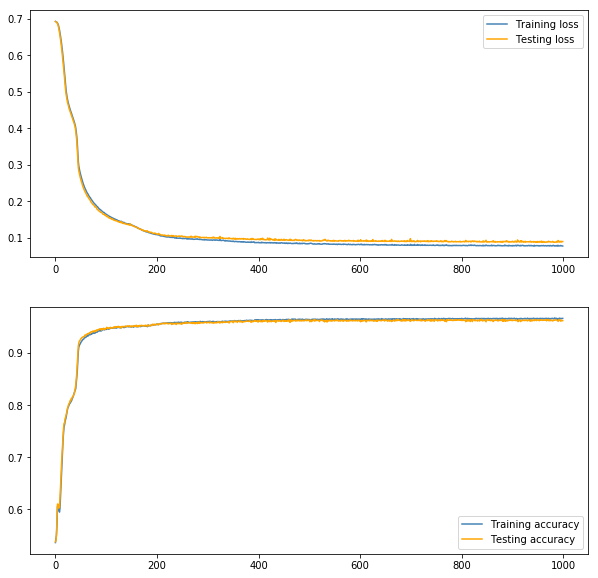

In [156]:
plot_learning_curve(ffnn_fitting.history)

## Mutual information between layers

### Test

In [157]:
def output_of_nth_layer(n, x):
    intermediate_layer_model = Model(
        inputs=ffnn.input,
        outputs=ffnn.layers[n].output)
    return intermediate_layer_model.predict(x)

In [158]:
%%time
dataset_through_layers_test = [X_test] + [output_of_nth_layer(n, X_test) for n in range(len(ffnn.layers))]

CPU times: user 888 ms, sys: 60 ms, total: 948 ms
Wall time: 706 ms


In [162]:
%%time
def g(x, y):
    print('One more!')
    return mutual_information(x, y)

mutual_information_X = list(map(
    lambda x: g(X_test, x), 
    dataset_through_layers_test))

One more!
One more!
One more!
One more!
One more!
One more!
CPU times: user 1min 32s, sys: 8 ms, total: 1min 32s
Wall time: 1min 30s


In [164]:
mutual_information_X

[11.95634385953802,
 9.523313637410636,
 7.573428635116021,
 5.979453910667301,
 4.100347129383793,
 0.7735857786345307]

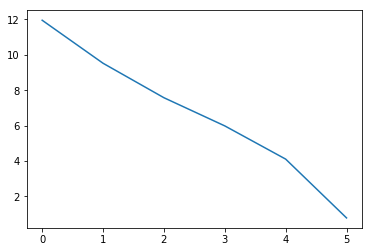

In [163]:
plt.plot(mutual_information_X)
plt.show()

In [159]:
%%time
def g1(x, y):
    print('One more!')
    return mixed_mutual_information(x, y, k=500)

mutual_information_Y = list(map(
    lambda x: g1(x, Y_test), 
    dataset_through_layers_test))

One more!
One more!
One more!
One more!
One more!
One more!
CPU times: user 1min, sys: 128 ms, total: 1min 1s
Wall time: 45.5 s


In [160]:
mutual_information_Y

[0.1454857792925921,
 0.6244121735995374,
 0.05632555711496434,
 0.617826427249279,
 0.809504458257019,
 0.7533925038217584]

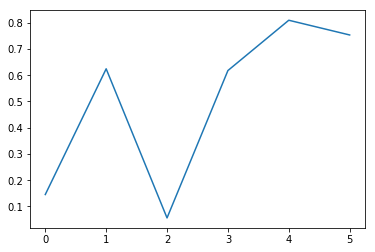

In [161]:
plt.plot(mutual_information_Y)
plt.show()

### Train

In [165]:
%%time
dataset_through_layers_train = [X_train] + [output_of_nth_layer(n, X_train) for n in range(len(ffnn.layers))]

CPU times: user 1.75 s, sys: 96 ms, total: 1.85 s
Wall time: 1.41 s


In [166]:
%%time
mutual_information_X = list(map(
    lambda x: g(X_train, x), 
    dataset_through_layers_train))

One more!
One more!
One more!
One more!
One more!
One more!
CPU times: user 13min 41s, sys: 60 ms, total: 13min 41s
Wall time: 13min 32s


In [167]:
mutual_information_X

[12.956379927816764,
 10.420854447502922,
 8.330311151529667,
 6.605510130735363,
 4.612506912053215,
 0.8752452800797217]

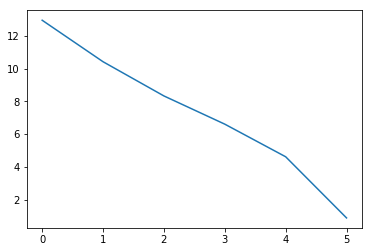

In [168]:
plt.plot(mutual_information_X)
plt.show()

In [169]:
%%time
mutual_information_Y = list(map(
    lambda x: g1(x, Y_train), 
    dataset_through_layers_train))

One more!
One more!
One more!
One more!
One more!
One more!
CPU times: user 7min 35s, sys: 424 ms, total: 7min 35s
Wall time: 6min 56s


In [170]:
mutual_information_Y

[0.15580455516767744,
 0.27760657673057887,
 0.3374981009182835,
 0.724272657930823,
 0.8415090005280144,
 0.8407423043025037]

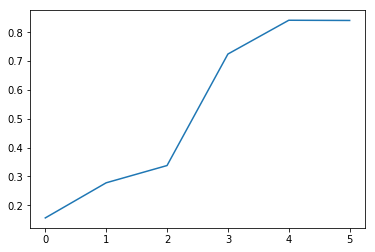

In [171]:
plt.plot(mutual_information_Y)
plt.show()